## Домашнее задание 14
### Козел А.Г. v1
15.11.2022

Проанализировать данные по выживаемости. Обучить модель предсказания выживет ли человек или нет (ключевая переменная) (различные варианты визуализации можно посмотреть здесь https://www.kaggle.com/competitions/titanic/code?competitionId=3136&sortBy=scoreDescending&language=Python).
Определить наиболее значимые переменные которые влияют на выживаемость. 
Визуализировать дерево решений. 
Написать вывод. 
Не копировать бездумно чужие работы. 


Ответить на вопросы (обоснованно).

1. Как влияет размер семьи  на вероятность виживаемости (одинокие выживают чаще или нет?, люди у которых большая семья (больше 4) выживают чаще или нет).
2. Как влияет пол/возраст/номер палубы. 


### Описание 
* survival	Survival 	0 = No, 1 = Yes    
Выживание     
* pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
* sex	Sex	
* Age	Age in years	
* sibsp	# of siblings / spouses aboard the Titanic	 
братья и сестры / супруги на борту Титаника
* parch	# of parents / children aboard the Titanic	
родители/дети на борту Титаника
* ticket	Ticket number	
* fare	Passenger fare	
Пассажирский тариф
* cabin	Cabin number
Номер каюты
* embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton  
прибывает в порт посадки C = Шербур, Q = Квинстаун, S = Саутгемптон

In [1]:
# Загружаем требуемые библиотеки.
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score


In [2]:
df_train = pd.read_csv('titanic_train.csv', sep=',', encoding="cp1251") 
df_test = pd.read_csv('titanic_test.csv', sep=',', encoding="cp1251") 


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
#убираю столбец "PassengerId "
df_train = pd.DataFrame(df_train,columns=['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'])


In [7]:
# количество уникальных значений
df_train.nunique()

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64

In [8]:
# Выжившие
df_train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [12]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## Как влияет размер семьи на вероятность виживаемости (одинокие выживают чаще или нет?, люди у которых большая семья (больше 4) выживают чаще или нет).

In [13]:
# Наличие братье/сестер/супругов
df_train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

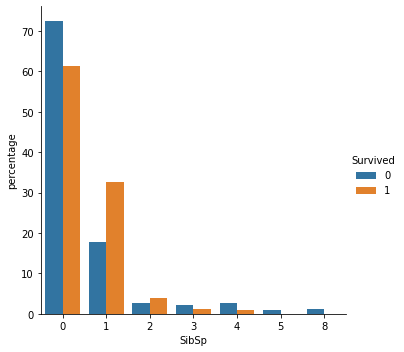

In [14]:
Survived_def = (df_train.groupby(['Survived'])['SibSp']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('SibSp'))

ax = sns.catplot(x="SibSp", y="percentage", hue="Survived", data=Survived_def, kind='bar')


In [15]:
# Наличие родителей/детей
df_train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

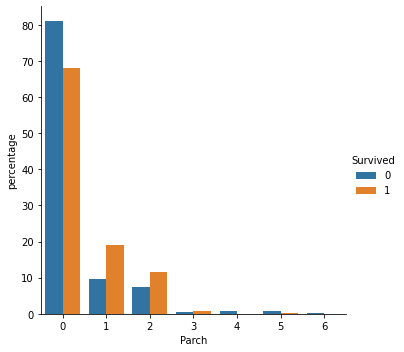

In [16]:
Survived_def = (df_train.groupby(['Survived'])['Parch']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('Parch'))

ax = sns.catplot(x="Parch", y="percentage", hue="Survived", data=Survived_def, kind='bar')

## Вывод
Выживаемость выше была не у одиноких людей, а у людей с 1-2 SibSp (братья/сестры/супруги) или 1-3 Parch (родители/дети). При наличии более 4 SibSp или Parch шансы выжить были минимальны.

### Введу новый столбец, где будет учитываться все родственники сразу. Оценю его влияние на выживаемость.

In [17]:
df_train_copy = df_train.copy(deep=True)

In [18]:
df_train_copy['relatives'] = df_train_copy['Parch']+ df_train_copy['SibSp']
df_train_copy

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,relatives
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,3
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0


In [19]:
# Количество родственников
df_train_copy['relatives'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: relatives, dtype: int64

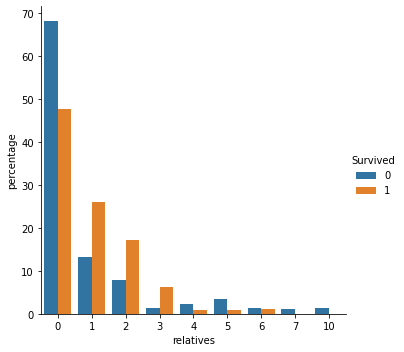

In [50]:
Survived_def = (df_train_copy.groupby(['Survived'])['relatives']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('relatives'))

a1 = sns.catplot(x="relatives", y="percentage", hue="Survived", data=Survived_def, kind='bar')


## Вывод
В принципе предыдущие выводы подтверждаются. Выживаемость гораздо выше была у людей путешествующих семьей из 1-3 человек.

C:\Users\37533\AppData\Local\Temp\ipykernel_10744\3149692977.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Survived_def = (df_train_copy.groupby(['Survived'])['relatives', 'Sex']


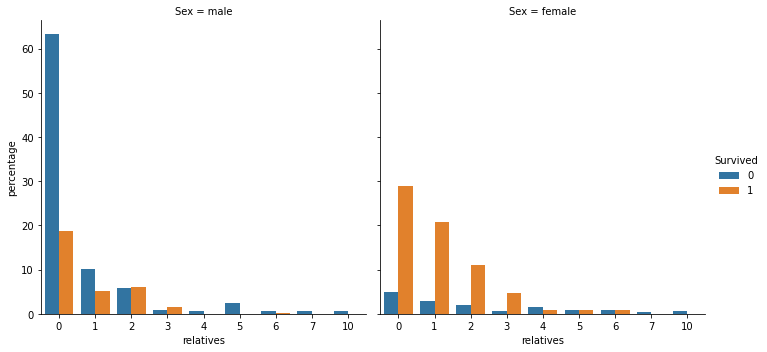

In [41]:
Survived_def = (df_train_copy.groupby(['Survived'])['relatives', 'Sex']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('relatives'))

ax = sns.catplot(x="relatives", y="percentage", col = 'Sex', hue="Survived", data=Survived_def, kind='bar')

## Вывод
Интересная картина наблюдается, если разделить эти варианты в зависимости от пола

## Как влияет пол/возраст/номер палубы.

In [21]:
#  Пол
df_train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

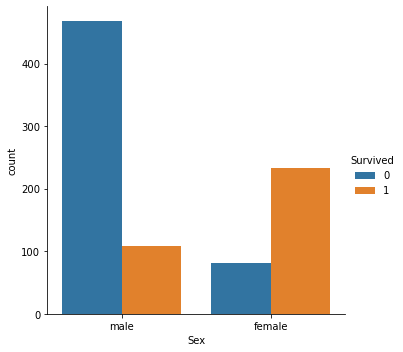

In [22]:
sns.catplot(data = df_train,hue = 'Survived', x = 'Sex', kind='count')

In [54]:
# Класс
df_train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [59]:
df_train[['Pclass','Survived']].value_counts()

Pclass  Survived
3       0           372
1       1           136
3       1           119
2       0            97
        1            87
1       0            80
dtype: int64

 ## Вывод
 в 3 классе выжило примерно 24.2%, во 2 классе - 47.3%, в 1 классе - 63%.

C:\Users\37533\AppData\Local\Temp\ipykernel_10744\906175200.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Survived_def = (df_train.groupby(['Survived'])['Pclass', 'Sex']


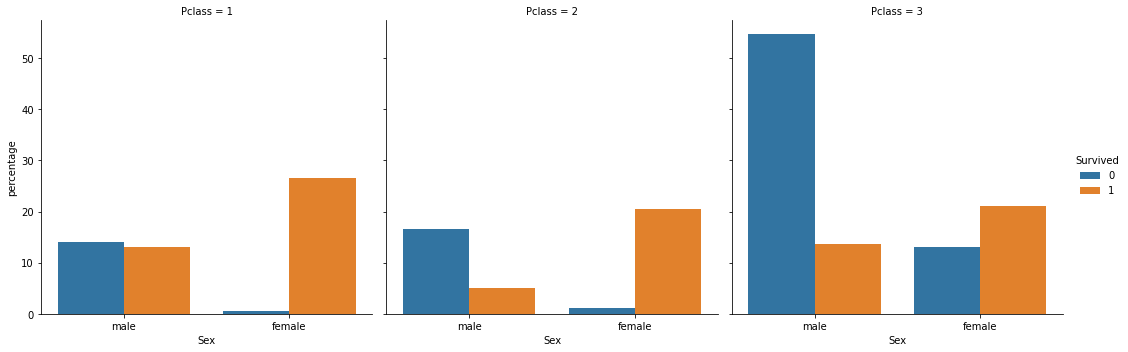

In [97]:
Survived_def = (df_train.groupby(['Survived'])['Pclass', 'Sex']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('Pclass'))

ax=sns.catplot(x="Sex",col='Pclass', y="percentage", hue="Survived", data=Survived_def, kind='bar')


In [60]:
df_train[['Sex','Survived']].value_counts()

Sex     Survived
male    0           468
female  1           233
male    1           109
female  0            81
dtype: int64

## Вывод
Хорошо было быть женщиной, особенно в 1 или 2 классе. Очень заметно, что шансы выжить очень сильно зависили от класса и от пола. 
Мужчин выжило 18,9%, женщин - 74,2%.

In [24]:
# Возраст
df_train['Age'].value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64

<AxesSubplot:>

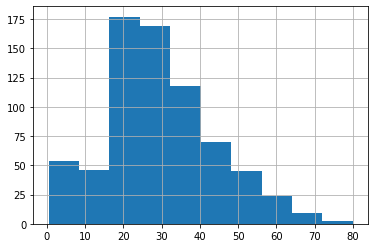

In [37]:
df_train.Age.hist()

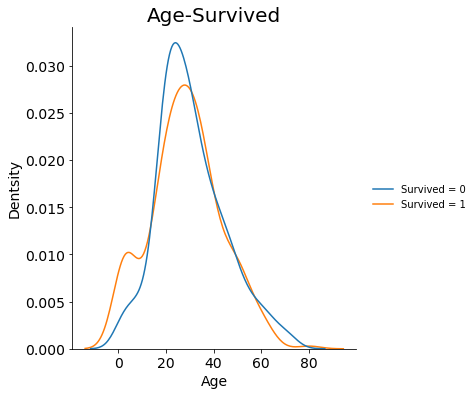

In [90]:
sns.displot(
    {
        "Survived = 0": df_train[df_train.Survived == 0].Age,
        "Survived = 1": df_train[df_train.Survived == 1].Age,
       
    },
    kind="kde",
    common_norm=False
)

plt.title('Age-Survived', fontsize=20)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

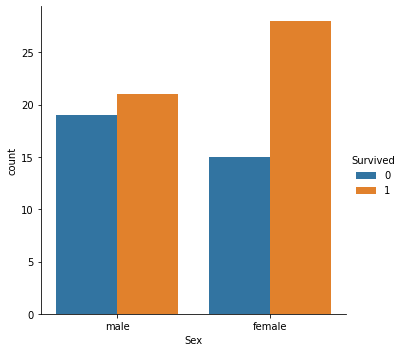

In [115]:
# Примем за детей возраст до 16.  После 16 выживаемость хуже.
child= df_train[df_train.Age<16]
sns.catplot(data = child,hue = 'Survived', 
            x = 'Sex',kind='count')

<AxesSubplot:xlabel='Count', ylabel='Age'>

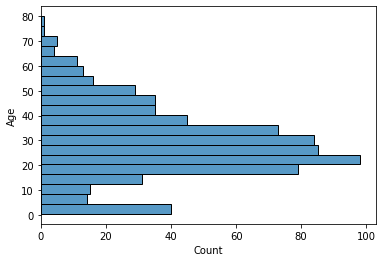

In [129]:
sns.histplot(data=df_train, y= df_train['Age'])

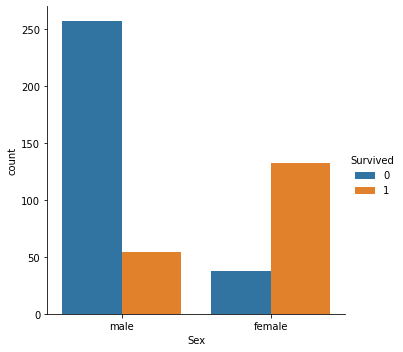

In [130]:
# Выбираю такие рамки ориентируясь на график. Примерно после 38
adults= df_train[(df_train.Age>=16)&(df_train.Age<=40)]
sns.catplot(data = adults,hue = 'Survived', 
            x = 'Sex',kind='count')

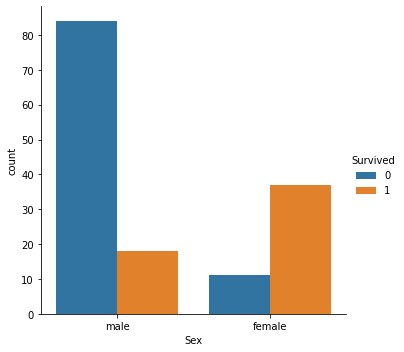

In [131]:
# Примем за детей возраст до подрасткового
senior= df_train[df_train.Age>40]
sns.catplot(data = senior,hue = 'Survived', 
            x = 'Sex',kind='count')

## Вывод
Если смотреть по возрасту, то вероятность выжить у мужчин выше, чем смертность только в случае возраста до 16.


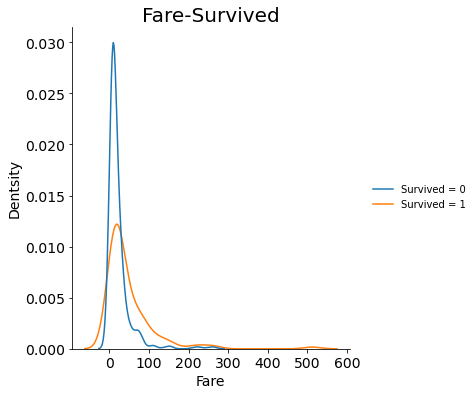

In [63]:
sns.displot(
    {
        "Survived = 0": df_train[df_train.Survived == 0].Fare,
        "Survived = 1": df_train[df_train.Survived == 1].Fare,
       
    },
    kind="kde",
    common_norm=False
)

plt.title('Fare-Survived', fontsize=20)
plt.xlabel('Fare', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

## Модель "Baseline" на основе логических выводов

In [156]:
# По результатам анализа можно сделать ряд допущений
df_train['result'] = 1
df_train.loc[(df_train.Sex == 'male')&(df_train.Pclass == 3), 'result'] = 0
df_train.loc[(df_train.Sex == 'male')&(df_train.Age > 50), 'result'] = 0
df_train.loc[(df_train.Sex == 'male')&(df_train.Age >=20)&(df_train.Age <=38), 'result'] = 0
df_train.loc[(df_train.Sex == 'female')&(df_train.Age > 60), 'result'] = 1
df_train.loc[(df_train.Sex == 'female')&(df_train.Pclass == 1), 'result'] = 1
df_train.loc[(df_train.Sex == 'female')&(df_train.Pclass == 2), 'result'] = 1
df_train.loc[(df_train.SibSp > 3)&(df_train.Parch > 3), 'result'] = 0


In [157]:
df_train['errors'] = (df_train.Survived - df_train.result)**2
1 - df_train.errors.sum() / df_train.shape[0]

0.7508417508417509

In [164]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer

In [ ]:
df_cleaned = pd.concat([df_train,
           pd.get_dummies(df_train['Sex'], prefix='Sex'),
           pd.get_dummies(df_train['marital_status'], prefix='marital_status'),
           pd.get_dummies(df_train['job_position'], prefix='job_position'),
           pd.get_dummies(df_traind['education'], prefix='education'),
           pd.get_dummies(df_train['living_region'], prefix='living_region')], axis=1)

In [160]:
y = df_train['Survived']
X = df_train.drop(['Survived'], axis=1)

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=42)